### Imports

In [3]:
import os
# os.environ['PATH'] = '/usr/local/cuda-11.6/bin:' + os.environ['PATH']
if 'notebooks' not in os.listdir(os.getcwd()):
    os.chdir('../') #changing directories so that output/gsplat_full etc. exists

from contextlib import redirect_stdout
from video_api import initialize_gaussians
from gaussian_renderer import render
import sys 
import torch 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from utils.mujoco_utils import compute_camera_extrinsic_matrix, compute_camera_intrinsic_matrix
from utils.mujoco_utils import get_canonical_pose, set_xml_light_params, find_non_collision_pose, save_robot_metadata, ControlRobot
import mujoco
from utils.graphics_utils import getWorld2View2, getProjectionMatrix, se3_to_SE3
from IPython.display import Image as IPImage
from moviepy import ImageSequenceClip
from scipy.spatial.transform import Rotation 
import cv2
from notebooks.utils import Utils


### Functions

In [116]:
def display_render(image_tensor: torch.Tensor):
    im = image_tensor.detach().permute(1, 2, 0).cpu().numpy()
    im = (im * 255).astype(np.uint8)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

def pad_to_match_aspect(image, target_aspect_ratio):
    """
    Pads the input image (rendered image) to match the target aspect ratio.
    
    Args:
        image (torch.Tensor): Input image of shape [C, H, W].
        target_aspect_ratio (float): Target aspect ratio (width / height).

    Returns:
        torch.Tensor: Padded image with the target aspect ratio.
    """
    _, h, w = image.shape
    current_aspect_ratio = w / h

    if current_aspect_ratio < target_aspect_ratio:
        # Add padding to width
        new_width = int(h * target_aspect_ratio)
        pad = (new_width - w) // 2
        padding = (pad, pad, 0, 0)  # (left, right, top, bottom)
    else:
        # Add padding to height
        new_height = int(w / target_aspect_ratio)
        pad = (new_height - h) // 2
        padding = (0, 0, pad, pad)  # (left, right, top, bottom)
    
    return F.pad(image.unsqueeze(0), padding, mode='constant', value=0).squeeze(0)

def enforce_homogeneous_transform(matrix):
    """
    Ensures the matrix retains the properties of a homogeneous transformation.
    - The rotation part (3x3) is orthonormal.
    - The last row is [0, 0, 0, 1].
    """
    with torch.no_grad():
        # Extract the rotation part (3x3)
        rotation = matrix[:3, :3]
        
        # Re-orthogonalize using SVD
        u, _, v = torch.svd(rotation)
        rotation_orthogonal = torch.mm(u, v.t())
        
        # Update the matrix with the orthogonal rotation
        matrix[:3, :3] = rotation_orthogonal
        
        # Ensure the last row is [0, 0, 0, 1]
        matrix[:, 3] = torch.tensor([0, 0, 0, 1], device=matrix.device)
    
    return matrix

def decompose_homogeneous_matrix(matrix):
    """
    Decomposes a homogeneous transformation matrix into Euler angles and translation.
    """
    rotation_matrix = matrix[:3, :3].T.cpu().numpy()
    translation = matrix[3, :3]
    
    # Convert rotation matrix to Euler angles
    euler_angles = torch.tensor(Rotation.from_matrix(rotation_matrix).as_euler('xyz', degrees=False), device=matrix.device)
    
    return euler_angles, translation

def assemble_homogeneous_matrix(euler_angles, translation):
    """
    Constructs a homogeneous transformation matrix from Euler angles and translation.
    """
    # Convert Euler angles to rotation matrix
    rotation_matrix = torch.tensor(Rotation.from_euler('xyz', euler_angles.detach().cpu().numpy(), degrees=False).as_matrix(), device=euler_angles.device)
    
    # Create a 4x4 homogeneous transformation matrix
    matrix = torch.eye(4, device=euler_angles.device)
    matrix[:3, :3] = rotation_matrix.T
    matrix[3, :3] = translation
    
    return matrix


# def assemble_homogeneous_matrix(euler_angles, translation): 
#     """
#     Constructs a homogeneous transformation matrix from Euler angles and translation,
#     while preserving gradients.
#     """
#     # Extract individual angles
#     roll, pitch, yaw = euler_angles.unbind(0)

#     # Compute rotation matrix elements
#     c1, s1 = torch.cos(roll), torch.sin(roll)
#     c2, s2 = torch.cos(pitch), torch.sin(pitch)
#     c3, s3 = torch.cos(yaw), torch.sin(yaw)

#     # Construct rotation matrix
#     rotation_matrix = torch.stack([
#         torch.tensor([c2 * c3, -c2 * s3, s2], device=euler_angles.device),
#         torch.tensor([s1 * s2 * c3 + c1 * s3, -s1 * s2 * s3 + c1 * c3, -s1 * c2], device=euler_angles.device),
#         torch.tensor([-c1 * s2 * c3 + s1 * s3, c1 * s2 * s3 + s1 * c3, c1 * c2], device=euler_angles.device)
#     ])

#     # Create a 4x4 homogeneous transformation matrix
#     matrix = torch.eye(4, device=euler_angles.device)
#     matrix[:3, :3] = rotation_matrix
#     matrix[:3, 3] = translation

#     return matrix

def optimization(camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, euler_angles, translation, num_iterations=200, plot_loss_flag=False):
    video = []
    losses = []
    threshold = 100
    for i in range(num_iterations):
        # make sure translation is not nan:
        if torch.isnan(translation).any():
            translation = torch.tensor([0.0, 0.0, 0.0], device=translation.device).requires_grad_(True)
            print("translation is nan")
            break

        world_view_transform_result = assemble_homogeneous_matrix(euler_angles, translation)

        # Update the example_camera's parameters
        camera.joint_pose = joint_pose_result
        camera.world_view_transform = world_view_transform_result
        # print("euler_angles:", euler_angles)
        # print("translation:", translation)
        # print("world_view_transform_result:", world_view_transform_result)

        # Render the image with the current parameters
        # r = render(camera, gaussians, background_color)['render']
        # s = extract_outline_with_original_pixels_differentiable(r.squeeze(0))
        s = render(camera, gaussians, background_color)['render']
        rendered_silhouette = torch.clamp(s, 0, 1)
        sparsity_penalty = torch.sum(rendered_silhouette) < threshold  # Penalize sparse renderings
        # padded_rendered_image = pad_to_match_aspect(rendered_image, target_aspect_ratio)

        # Compute the loss between the rendered image and the reference image
        loss = loss_fn(rendered_silhouette, reference_image.squeeze(0)) + sparsity_penalty * 1e-2 
        losses.append(loss.item())
        # print("Gradients for euler_angles:", euler_angles.grad)
        # print("Gradients for translation:", translation.grad)
        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Update the parameters
        optimizer.step()
        # world_view_transform_result = enforce_homogeneous_transform(world_view_transform_result)
        # Print progress
        if i % 10 == 0:
            print(f"Iteration {i}: Loss = {loss.item()}")
            # display_render(rendered_image)
            rendered_image = render(camera, gaussians, background_color)['render']
            frame = rendered_image.detach().cpu()
            # frame = frame.numpy()
            
            # ## use cv2 to print the iteration number on the image
            # frame = cv2.putText(frame, f"Iteration {i}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # frame = render(example_camera, gaussians, background_color)['render'] #3, 480, 480
            video.append(frame)
    if plot_loss_flag:
        plot_loss(losses)
    return video, joint_pose_result, assemble_homogeneous_matrix(euler_angles.detach(), translation.detach()), euler_angles, translation

def plot_loss(losses):
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss vs. Iteration')
    plt.show()

# Function to count the number of files in a folder
def count_files(path):
    return len([file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])


def make_video(video, filename, fps=30):
    video = torch.stack(video)
    video = torch.clamp(video, 0, 1)
    video = video.cpu().detach().numpy()
    video = np.transpose(video, (0, 2, 3, 1))    
    video = (video * 255).astype(np.uint8)

    clip = ImageSequenceClip(list(video), fps=fps)
    clip.write_gif(f"{filename}.gif")

def read_mp4_from_file(filename, start_frame=0, end_frame=None):
    cap = cv2.VideoCapture(filename)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

def configure_camera(sample_cameras, distance=0.1, azimuth=0.0, elevation=-20, lookat=(0,0,-0.4), theta=-np.pi / 2, trans=(0, -0.5, 0)):
    example_camera = sample_cameras[0]

    ## Customize camera parameters
    cam = mujoco.MjvCamera()
    mujoco.mjv_defaultCamera(cam)
    cam.distance = distance
    cam.azimuth = azimuth
    cam.elevation = elevation
    cam.lookat = lookat
    extrinsic = compute_camera_extrinsic_matrix(cam)
    w2v = getWorld2View2(extrinsic[:3, :3].T, extrinsic[:3, 3], np.array([0.0, 0.0, 0.0]), 1.0)

    ## form rotation matrix
    R_z = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0,              0,             1]
    ])

    R = w2v[:3, :3]
    t = w2v[:3, 3]

    # Apply translation
    t[0] = trans[0]
    t[1] = trans[1]
    t[2] = trans[2]

    # Apply the rotation
    R_rotated = R_z @ R  # Rotate the original rotation matrix
    t_rotated = R_z @ t  # Rotate the translation vector

    # Combine back into a transformation matrix
    T_rotated = np.eye(4)
    T_rotated[:3, :3] = R_rotated
    T_rotated[:3, 3] = t_rotated

    T_rotated_torch = torch.tensor(T_rotated, dtype=example_camera.world_view_transform.dtype).transpose(0, 1).to(example_camera.data_device)

    # example_camera.world_view_transform = T_rotated_torch
    # print("result transformation:", example_camera.world_view_transform)
    return T_rotated_torch


def multi_start_optimization(num_starts, neutral_pose, camera, gaussians, background_color, reference_image, loss_fn, optimizer_cls):
    best_loss = float('inf')
    best_joint_pose = None
    best_world_transform = None
    joint_pose_init = torch.tensor(neutral_pose, requires_grad=True, device="cuda")  # Initial joint pose
    distance=0.1
    azimuth=0.0
    elevation=-20
    lookat=(0,0,-0.4)
    theta=-np.pi / 2
    R_z = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0,              0,             1]
    ])
    trans=(0, -0.5, 0)

    joint_pose_lr = 2e-4
    rotation_lr = 3
    translation_lr = 5e-4
    for _ in range(num_starts):
        # Random initialization
        # joint_pose_init = torch.rand_like(camera.joint_pose).uniform_(-0.5, 0.5).requires_grad_(True)
        robot_in_frame = False
        while not robot_in_frame:
            distance_offset = np.random.uniform(-0.05, 0.05)
            azimuth_offset = np.random.uniform(-np.pi / 4, np.pi / 4)
            elevation_offset = np.random.uniform(-np.pi / 4, np.pi / 4)
            trans_offset = np.random.uniform(-0.1, 0.1)
            # trans[1] += trans_offset
            theta_offset = np.random.uniform(-np.pi / 4, np.pi / 4)

            transformation_init = configure_camera(camera, distance+distance_offset, azimuth+azimuth_offset, elevation+elevation_offset, lookat, theta+theta_offset, (0, -0.5+trans_offset, 0))
            cam = camera[0]
            cam.world_view_transform = transformation_init
            ## robot in frame (sum of the pixel values exceeds a threshold)
            frame = render(cam, gaussians, background_color)['render']
            # display_render(frame)
            robot_in_frame = torch.sum(frame) > 0.0
        
        # Optimizer
        # optimizer = optimizer_cls([joint_pose_init, transformation_init], lr=learning_rate)
        euler_angles, translation = decompose_homogeneous_matrix(cam.world_view_transform.clone().detach().cpu())
        euler_angles = torch.nn.Parameter(euler_angles, requires_grad=True)
        translation = torch.nn.Parameter(translation, requires_grad=True)
        optimizer = torch.optim.Adam([
            {"params": joint_pose_init, "lr": joint_pose_lr},
            {"params": euler_angles, "lr": rotation_lr},
            {"params": translation, "lr": translation_lr}
        ])
        # Optimization process
        _, joint_pose_result, world_transform_result, _, _ = optimization(
            cam, gaussians, background_color, reference_image, loss_fn,
            optimizer, joint_pose_init, transformation_init,
            euler_angles=euler_angles, translation=translation, num_iterations=100
        )
        
        # Evaluate final loss
        rendered_image = render(cam, gaussians, background_color)['render']
        loss = loss_fn(rendered_image, reference_image)
        display_render(torch.clamp(rendered_image, 0, 1))
        if loss < best_loss:
            print(f"New best loss: {loss.item()}")
            best_loss = loss
            best_joint_pose = joint_pose_result.clone()
            best_world_transform = world_transform_result.clone()
            best_euler_angles = euler_angles.clone()
            best_translation = translation.clone()
    
    return best_joint_pose, best_world_transform, best_euler_angles, best_translation
    
def generate_edge_silhouette(mask, device='cuda'):
    """
    Generate an edge silhouette from the binary mask.
    """
    # Define Sobel filters for edge detection
    sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
    sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
    
    # Add batch and channel dimensions to the mask
    mask = mask.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]

    # Apply Sobel filters
    edge_x = F.conv2d(mask, sobel_x, padding=1)  # Horizontal edges
    edge_y = F.conv2d(mask, sobel_y, padding=1)  # Vertical edges

    # Compute edge magnitude
    edges = torch.sqrt(edge_x**2 + edge_y**2).squeeze()  # Shape: [H, W]
    return edges

def generate_edge_map(image_tensor):

    """
    Generate an edge map from an image tensor using Sobel filters.
    The input image_tensor should be of shape (C, H, W) and normalized to [0, 1].
    """
    threshold = 0.2
    # Ensure the input is grayscale; if RGB, take the mean across channels
    if image_tensor.shape[0] == 3:  # Check for 3 channels
        image_tensor = image_tensor.mean(dim=0, keepdim=True)  # Convert to grayscale (1, H, W)

    # Define Sobel filters for edge detection
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=image_tensor.device).view(1, 1, 3, 3)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device=image_tensor.device).view(1, 1, 3, 3)

    # Apply Sobel filters to detect edges in both directions
    grad_x = F.conv2d(image_tensor.unsqueeze(0), sobel_x, padding=1)
    grad_y = F.conv2d(image_tensor.unsqueeze(0), sobel_y, padding=1)

    # Compute the magnitude of the gradient
    edge_map = torch.sqrt(grad_x ** 2 + grad_y ** 2).squeeze(0)  # Shape: (1, H, W) -> (H, W)

    # Normalize the edge map to [0, 1]
    edge_map = edge_map / edge_map.max()

    # Apply a threshold to create a binary black-and-white edge map
    edge_map_bw = (edge_map > threshold).float()

    return edge_map_bw

def extract_outline_with_original_pixels_differentiable(rendered_image, threshold=0.1):
    # Step 1: Convert the rendered image to grayscale (average the color channels)
    grayscale_image = rendered_image.mean(dim=0, keepdim=True)  # Convert to grayscale by averaging channels
    
    # Step 2: Apply Sobel filter to detect edges
    sobel_filter_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=rendered_image.device).view(1, 1, 3, 3)
    sobel_filter_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device=rendered_image.device).view(1, 1, 3, 3)
    
    # Apply the filters to detect edges in x and y directions
    grad_x = F.conv2d(grayscale_image.unsqueeze(0), sobel_filter_x, padding=1)
    grad_y = F.conv2d(grayscale_image.unsqueeze(0), sobel_filter_y, padding=1)
    
    # Step 3: Combine the gradients (edge magnitude)
    edge_magnitude = torch.sqrt(grad_x**2 + grad_y**2)
    
    # Step 4: Use a sigmoid function to create a smooth transition around edges
    edge_mask = torch.sigmoid(edge_magnitude * 100)  # Sigmoid to smooth edges (100 is a scale factor)

    # Step 5: Blend the original pixel values with the edge mask (this is differentiable)
    outline = rendered_image * edge_mask  # Retain original pixel values at edges, smooth transition elsewhere
    
    return outline



### Initialization

In [4]:
## ------ Initialize Gaussian Renderer ------ ##
sys.argv = ['']
gaussians, background_color, sample_cameras, kinematic_chain = initialize_gaussians(model_path='./output/p_short_exp_2', bg_color=[0, 0, 0])

# example_camera.image_height = 540
# example_camera.image_width = 960

Config file not found at
self.model_path ./output/p_short_exp_2
[Scene] Loading trained Gaussian model at iteration 60000
[Scene] Loading robot model from model path


/home/iulian/chole_ws/src/drrobot/scene/gaussian_model.py:304: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lrs = torch.load(os.path.join(os.path.dirname(path), 'lrs.pth'))

tensor(2135.3994, device='cuda:0', grad_fn=<SumBackward0>)
w2v: tensor([[-0.3742, -0.9178, -0.1330,  0.0000],
        [-0.6388,  0.1511,  0.7544,  0.0000],
        [-0.6723,  0.3673, -0.6428,  0.0000],
        [-0.3598,  0.1966, -0.2000,  1.0000]], requires_grad=True)
torch.Size([3, 256, 256])
torch.Size([256, 256, 1])
torch.Size([256, 256, 3])


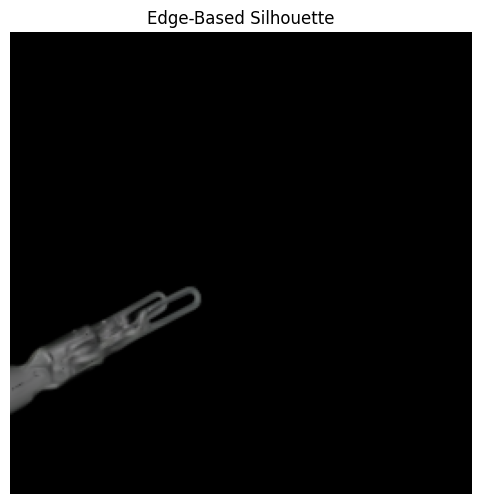

Sum of joint gradients: tensor(-273.8707)
Sum of camera gradients: tensor(31297.6641)


In [118]:
## ------ Render Init Gaussian ------ ##
example_camera = sample_cameras[0]
transformation = configure_camera(sample_cameras, distance=0.1, azimuth=100.0, elevation=-40, lookat=(0,0,-0.3), theta=-np.pi / 2 -0.5, trans=(-0.0, -0.41, -0.2))
example_camera.world_view_transform = transformation
n = len(kinematic_chain.get_joint_parameter_names())    
neutral_pose = [0.0, 0.125, 0.222, -0.203, 0.257]
# variance = [0.0597, 0.2111, 0.49, 0.1258, 0.49]

# robot_pose = np.random.normal(neutral_pose, np.sqrt(variance))
# # Clip to joint limits
# joint_limits = [[-1.22173, 1.22173], [-2.5, 2.0944], [-3.5, 3.5], [-1.0472, 2.5], [-3.5, 3.5]]
# pose_clipped = np.clip(robot_pose, [limit[0] for limit in joint_limits], [limit[1] for limit in joint_limits])

# example_camera.joint_pose = torch.tensor(pose_clipped,).requires_grad_(True)
example_camera.joint_pose = torch.tensor(neutral_pose,).requires_grad_(True)
example_camera.world_view_transform.requires_grad_(True)
result = render(example_camera, gaussians, background_color)

# Use the raw alpha channel as a continuous mask
mask = result['render']  # Continuous alpha values, directly from render_alphas
frame = mask  # Use the mask directly without clamping or thresholding
# Display the mask (optional, normalized for visualization)
# display_render(torch.clamp(mask, 0, 1))
print(torch.sum(frame))
print("w2v:", example_camera.world_view_transform)
frame.sum().backward()


print(frame.shape)
grayscale_image = frame.mean(dim=0, keepdim=True)  # Convert to grayscale by averaging channels
edge = generate_edge_silhouette(grayscale_image.squeeze(0))
print(edge.unsqueeze(0).permute(1, 2, 0).shape)
edge_silhouette = extract_outline_with_original_pixels_differentiable(frame)

# Convert to NumPy for visualization
edge_silhouette_np = edge_silhouette.detach().cpu().numpy()
print(edge_silhouette.squeeze(0).permute(1, 2, 0).shape)

# Plot the edge silhouette
plt.figure(figsize=(6, 6))
plt.imshow(edge_silhouette.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.title("Edge-Based Silhouette")
plt.show()

# plt.imshow(edge.unsqueeze(0).permute(1, 2, 0).detach().cpu().numpy())
# plt.axis('off')
# plt.show()
print('Sum of joint gradients:', example_camera.joint_pose.grad.sum())
print('Sum of camera gradients:', example_camera.world_view_transform.grad.sum())

1.0


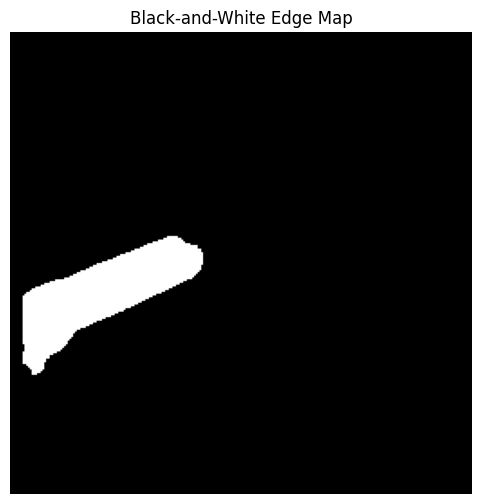

In [119]:
## ------ Display Reference Image ------ ##
original_image_path = "/home/iulian/chole_ws/src/sam2/data/simple_chole/grab_1/0.jpg"  # Path to your reference image
reference_image_path = "/home/iulian/chole_ws/src/sam2/segment_results_simple/frame_0_id_1.jpg"  # Path to your reference image
# original_image_path = "/home/iulian/chole_ws/src/sam2/data/tissue_80/grab/000000.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/src/sam2/segment_results/frame_0_id_1.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/mask_2.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/segmented_tool_8_0.jpg"  # Path to your reference image
# reference_image_path = "/home/iulian/chole_ws/data/base_chole_clipping_cutting/tissue_77/1_grabbing_gallbladder/20240907-090634-569257/left_img_dir/frame000017_left.jpg"  # Path to your reference image

## read the image
original_image = Image.open(original_image_path).convert('RGB')
reference_image = Image.open(reference_image_path).convert('RGB')

## crop the image to be square
reference_image = torch.tensor(np.array(reference_image) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
reference_image = pad_to_match_aspect(reference_image, 1.0)
# reference_image = np.array(reference_image)[:540, :540]
reference_image = F.interpolate(reference_image.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)

# reference_image = generate_edge_map(reference_image)

# Display or save the edge map
plt.figure(figsize=(6, 6))
plt.imshow(reference_image.squeeze(0).permute(1,2,0).cpu().numpy())
plt.title("Black-and-White Edge Map")
plt.axis("off")

# Calculate target aspect ratio (reference image)
target_aspect_ratio = reference_image.shape[2] / reference_image.shape[1]

# Pad the rendered image to match the aspect ratio of the reference image
print(target_aspect_ratio)


### Optimization

In [120]:
## ------ Setting Optimization Parameters ------ ##

# Initialize parameters
joint_pose_result = torch.tensor(neutral_pose, requires_grad=True, device="cuda")  # Initial joint pose
world_view_transform_result = example_camera.world_view_transform.clone().detach().requires_grad_(True)  # Initial camera transform

# Define different learning rates
# joint_pose_lr = 2e-4
# world_transform_lr = 1e-4

joint_pose_lr = 2e-4
rotation_lr = 3
translation_lr = 1e-4
# Initialize the optimizer with parameter groups
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": world_view_transform_result, "lr": world_transform_lr}
# ])
euler_angles, translation = decompose_homogeneous_matrix(example_camera.world_view_transform.clone().detach().cpu())
euler_angles = torch.nn.Parameter(euler_angles, requires_grad=True)
translation = torch.nn.Parameter(translation, requires_grad=True)

# Define optimizer with separate learning rates
optimizer = torch.optim.Adam([
    {"params": joint_pose_result, "lr": joint_pose_lr},
    {"params": euler_angles, "lr": rotation_lr},
    {"params": translation, "lr": translation_lr}
])

num_iterations = 500
num_starts = 10
loss_fn = torch.nn.MSELoss()
video = []

print(euler_angles)

Parameter containing:
tensor([ 2.2765,  0.1334, -1.9579], dtype=torch.float64, requires_grad=True)


Iteration 0: Loss = 0.048816513270139694
Iteration 10: Loss = 0.041381727904081345
Iteration 20: Loss = 0.039630092680454254
Iteration 30: Loss = 0.038666337728500366
Iteration 40: Loss = 0.03780604898929596
Iteration 50: Loss = 0.0370674692094326
Iteration 60: Loss = 0.036284010857343674
Iteration 70: Loss = 0.03541511669754982
Iteration 80: Loss = 0.034361910074949265
Iteration 90: Loss = 0.033072344958782196


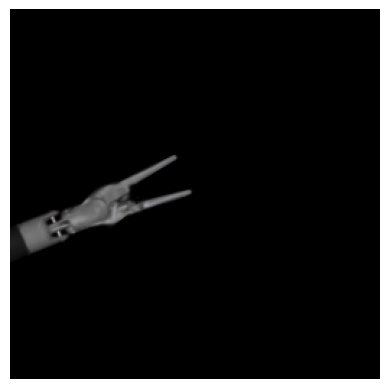

New best loss: 0.03167889267206192
Iteration 0: Loss = 0.05118611454963684
Iteration 10: Loss = 0.05112127587199211
Iteration 20: Loss = 0.05106329172849655
Iteration 30: Loss = 0.05100533366203308
Iteration 40: Loss = 0.05095381289720535
Iteration 50: Loss = 0.05090148001909256
Iteration 60: Loss = 0.05086047202348709
Iteration 70: Loss = 0.05082356557250023
Iteration 80: Loss = 0.050785090774297714
Iteration 90: Loss = 0.050758108496665955


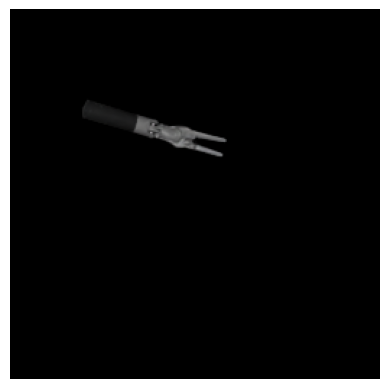

Iteration 0: Loss = 0.05153624340891838
Iteration 10: Loss = 0.05144881457090378
Iteration 20: Loss = 0.0513654425740242
Iteration 30: Loss = 0.05128799006342888
Iteration 40: Loss = 0.05122099071741104
Iteration 50: Loss = 0.05116220936179161
Iteration 60: Loss = 0.051110826432704926
Iteration 70: Loss = 0.051069475710392
Iteration 80: Loss = 0.05104156583547592
Iteration 90: Loss = 0.05101391300559044


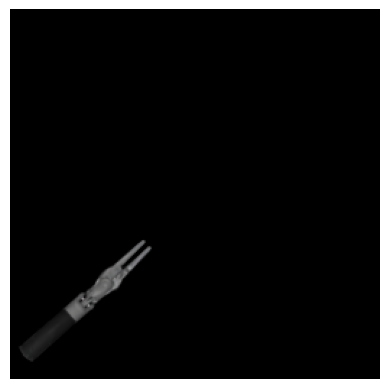

Iteration 0: Loss = 0.05131244659423828
Iteration 10: Loss = 0.051238980144262314
Iteration 20: Loss = 0.051168292760849
Iteration 30: Loss = 0.0511021614074707
Iteration 40: Loss = 0.051046937704086304
Iteration 50: Loss = 0.05099307745695114
Iteration 60: Loss = 0.050949111580848694
Iteration 70: Loss = 0.05089978501200676
Iteration 80: Loss = 0.05082165449857712
Iteration 90: Loss = 0.050744980573654175


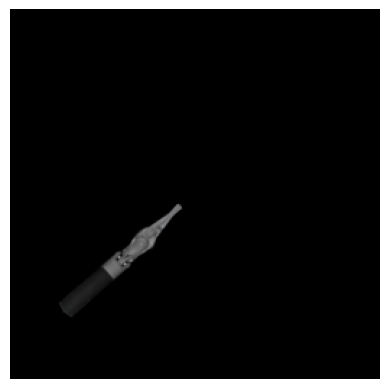

Iteration 0: Loss = 0.059035442769527435
Iteration 10: Loss = 0.059035442769527435
Iteration 20: Loss = 0.059035442769527435
Iteration 30: Loss = 0.059035442769527435
Iteration 40: Loss = 0.059035442769527435
Iteration 50: Loss = 0.059035442769527435
Iteration 60: Loss = 0.059035442769527435
Iteration 70: Loss = 0.059035442769527435
Iteration 80: Loss = 0.059035442769527435
Iteration 90: Loss = 0.059035442769527435


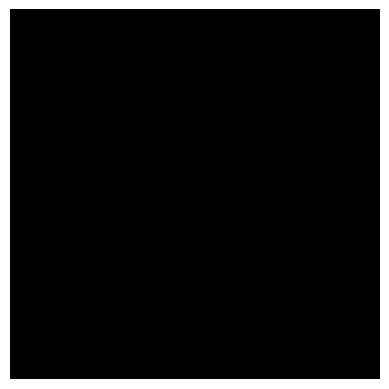

Iteration 0: Loss = 0.04500069469213486
Iteration 10: Loss = 0.042338766157627106
Iteration 20: Loss = 0.03973691910505295
Iteration 30: Loss = 0.03832834213972092
Iteration 40: Loss = 0.03730126842856407
Iteration 50: Loss = 0.03626584634184837
Iteration 60: Loss = 0.035139281302690506
Iteration 70: Loss = 0.03386411815881729
Iteration 80: Loss = 0.032762959599494934
Iteration 90: Loss = 0.032222382724285126


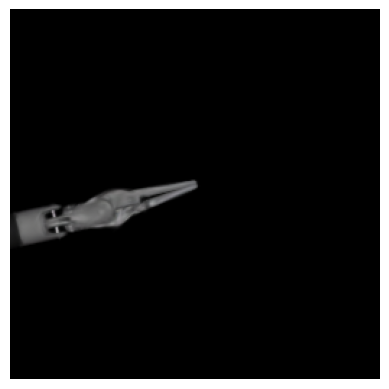

Iteration 0: Loss = 0.05021129176020622
Iteration 10: Loss = 0.04775562509894371
Iteration 20: Loss = 0.04699348658323288
Iteration 30: Loss = 0.04595630615949631
Iteration 40: Loss = 0.04513738304376602
Iteration 50: Loss = 0.044452182948589325
Iteration 60: Loss = 0.04424385726451874
Iteration 70: Loss = 0.04408222436904907
Iteration 80: Loss = 0.043861888349056244
Iteration 90: Loss = 0.04347663372755051


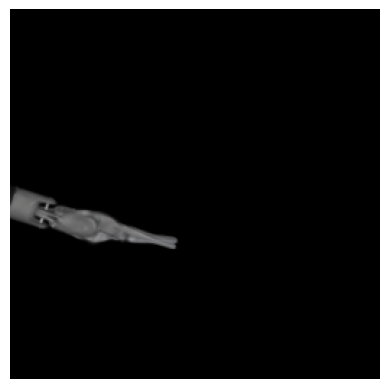

Iteration 0: Loss = 0.0591588094830513
Iteration 10: Loss = 0.059035442769527435
Iteration 20: Loss = 0.059035442769527435
Iteration 30: Loss = 0.059035442769527435
Iteration 40: Loss = 0.059035442769527435
Iteration 50: Loss = 0.059035442769527435
Iteration 60: Loss = 0.059035442769527435
Iteration 70: Loss = 0.059035442769527435
Iteration 80: Loss = 0.059035442769527435
Iteration 90: Loss = 0.059035442769527435


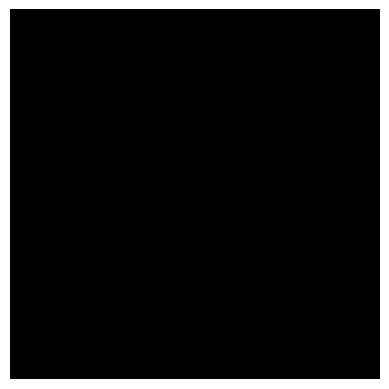

Iteration 0: Loss = 0.05156242102384567
Iteration 10: Loss = 0.051463495939970016
Iteration 20: Loss = 0.05139889568090439
Iteration 30: Loss = 0.05098795145750046
Iteration 40: Loss = 0.050413280725479126
Iteration 50: Loss = 0.04957500845193863
Iteration 60: Loss = 0.059221625328063965
Iteration 70: Loss = 0.05903753638267517
Iteration 80: Loss = 0.059035442769527435
Iteration 90: Loss = 0.059035442769527435


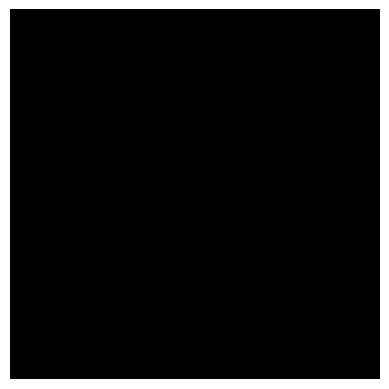

Iteration 0: Loss = 0.050837185233831406
Iteration 10: Loss = 0.04748902842402458
Iteration 20: Loss = 0.045586954802274704
Iteration 30: Loss = 0.04447174072265625
Iteration 40: Loss = 0.043978940695524216
Iteration 50: Loss = 0.04384815692901611
Iteration 60: Loss = 0.04357261583209038
Iteration 70: Loss = 0.04310370609164238
Iteration 80: Loss = 0.042835548520088196
Iteration 90: Loss = 0.0424189567565918


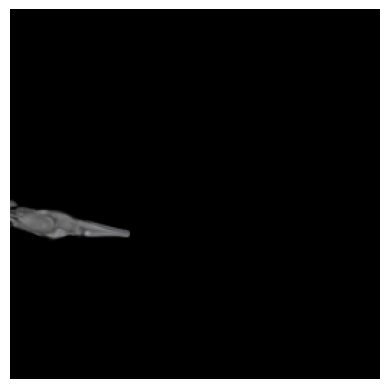

In [121]:
best_joint_pose, best_world_transform, best_euler, best_trans = multi_start_optimization(num_starts, neutral_pose, sample_cameras, gaussians, background_color, reference_image, loss_fn, optimizer)

In [122]:
# example_camera.joint_pose = best_joint_pose
# # example_camera.world_view_transform =  best_world_transform
# # euler_angles, translation = decompose_homogeneous_matrix(example_camera.world_view_transform.clone().detach().cpu())
# world_view_transform_result = assemble_homogeneous_matrix(best_euler, best_trans)
# # Update the example_camera's parameters
# example_camera.world_view_transform = world_view_transform_result
# euler_angles, translation = decompose_homogeneous_matrix(example_camera.world_view_transform.clone().detach().cpu())
# euler_angles = torch.nn.Parameter(euler_angles, requires_grad=True)
# translation = torch.nn.Parameter(translation, requires_grad=True)

# # Define optimizer with separate learning rates
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": euler_angles, "lr": rotation_lr},
#     {"params": translation, "lr": translation_lr}
# ])

# num_iterations = 500
# num_starts = 10
# loss_fn = torch.nn.MSELoss()
# video = []


# final_render = torch.clamp(render(example_camera, gaussians, background_color)['render'], 0, 1)
# display_render(final_render)


Iteration 0: Loss = 0.0501680001616478
Iteration 10: Loss = 0.04699205979704857
Iteration 20: Loss = 0.043490633368492126
Iteration 30: Loss = 0.04056121036410332
Iteration 40: Loss = 0.03809482976794243
Iteration 50: Loss = 0.03645644336938858
Iteration 60: Loss = 0.03623763099312782
Iteration 70: Loss = 0.03603341802954674
Iteration 80: Loss = 0.03577383607625961
Iteration 90: Loss = 0.03551901876926422
Iteration 100: Loss = 0.03525388985872269
Iteration 110: Loss = 0.03496582433581352
Iteration 120: Loss = 0.03464294970035553
Iteration 130: Loss = 0.03429441899061203
Iteration 140: Loss = 0.03391927480697632
Iteration 150: Loss = 0.033517803996801376
Iteration 160: Loss = 0.03307986259460449
Iteration 170: Loss = 0.03260297328233719
Iteration 180: Loss = 0.03210607171058655
Iteration 190: Loss = 0.03174666315317154
Iteration 200: Loss = 0.03154885023832321
Iteration 210: Loss = 0.03139789402484894
Iteration 220: Loss = 0.0312221460044384
Iteration 230: Loss = 0.030912019312381744
It

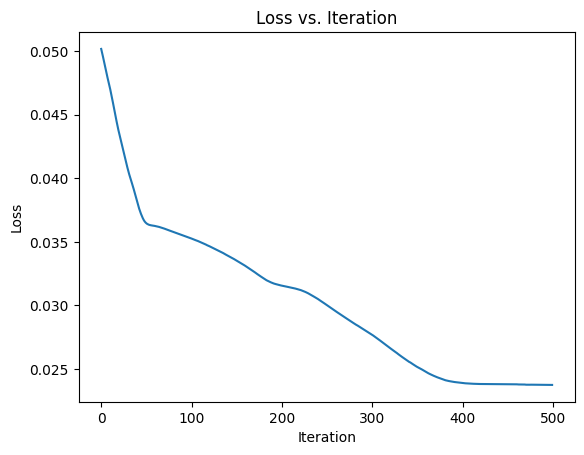

Final joint pose: tensor([-0.0317,  0.0552,  0.2951, -0.2398,  0.2085], device='cuda:0',
       requires_grad=True)
Final camera transform: tensor([[-0.3742, -0.9178, -0.1330,  0.0000],
        [-0.6388,  0.1511,  0.7544,  0.0000],
        [-0.6723,  0.3673, -0.6428,  0.0000],
        [-0.3449,  0.1837, -0.2530,  1.0000]])


In [123]:

# Optimization loop
video, joint_pose_result, world_view_transform_result, euler_angles_result, translation_result = optimization(example_camera, gaussians, background_color, reference_image, loss_fn, optimizer, joint_pose_result, world_view_transform_result, euler_angles, translation, num_iterations=num_iterations, plot_loss_flag=True)

# Final results
print("Final joint pose:", joint_pose_result)
print("Final camera transform:", world_view_transform_result)


MoviePy - Building file pose_est_init.gif with imageio.


frame_index:   0%|          | 0/49 [00:00<?, ?it/s, now=None]

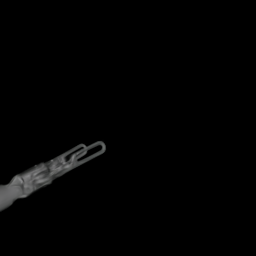

In [124]:
# ## ------ Save the video ------ ##
make_video(video, filename="pose_est_init", fps=10)
IPImage(filename="pose_est_init.gif")


(-0.5, 255.5, 255.5, -0.5)

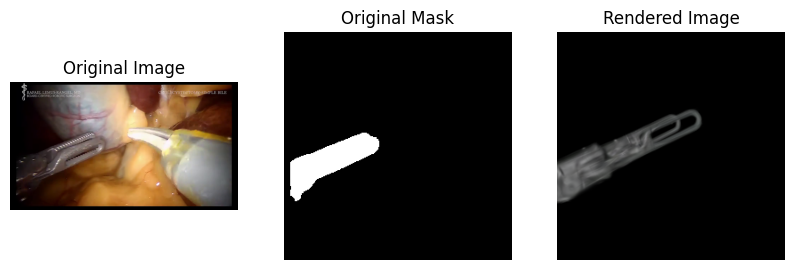

In [125]:
## ------ Compare the final rendered image and the reference image------ ##

final_render = torch.clamp(render(example_camera, gaussians, background_color)['render'], 0, 1)

# display_render(final_render)
padded_rendered_image = pad_to_match_aspect(final_render, target_aspect_ratio)
## subplot to show the original image and the rendered image
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 3, 1)
ax.set_title("Original Image")
ax.imshow(original_image)
ax.axis('off')

ax = plt.subplot(1, 3, 2)
ax.set_title("Original Mask")
ax.imshow(reference_image.squeeze(0).permute(1,2,0).cpu().numpy(), cmap='gray')
ax.axis('off')

subplot = plt.subplot(1, 3, 3)
subplot.set_title("Rendered Image")
subplot.imshow(final_render.detach().permute(1, 2, 0).cpu().numpy())
subplot.axis('off')


Number of images: 159
MoviePy - Building file init.gif with imageio.


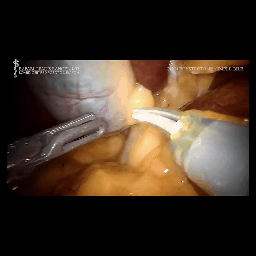

In [126]:
## ------ Iterate through the video ------ ##

# Path to the folder containing images
image_folder = "/home/iulian/chole_ws/src/sam2/data/simple_chole/grab_1"

# Count the number of files and prepare the image list
imgs = []
image_num = count_files(image_folder)
for i in range(int(image_num)):
    img_path = os.path.join(image_folder, f"{i}.jpg")
    img = Image.open(img_path)
    # img = np.array(img)[:540, :540]
    img = torch.tensor(np.array(img) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
    img = pad_to_match_aspect(img, 1.0)
    img = F.interpolate(img.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)
    imgs.append(img)

# Check number of images
print("Number of images:", len(imgs))

make_video(imgs, filename="init", fps=25)

IPImage(filename="init.gif")

Number of images: 159
MoviePy - Building file mask.gif with imageio.


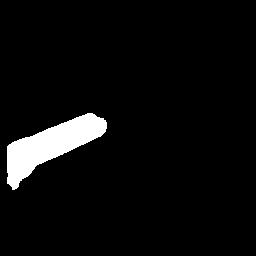

In [127]:
## ------ Iterate through the video ------ ##

# Path to the folder containing images
image_folder = "/home/iulian/chole_ws/src/sam2/segment_results_simple/"

# Count the number of files and prepare the image list
imgs = []
image_num = count_files(image_folder)
for i in range(int(image_num)):
    img_path = os.path.join(image_folder, f"frame_{i}_id_1.jpg")
    img = Image.open(img_path)
    # img = np.array(img)[:540, :540]

    img = torch.tensor(np.array(img) / 255.0).permute(2, 0, 1).float().to("cuda")  # Normalized [0, 1]
    img = pad_to_match_aspect(img, 1.0)
    img = F.interpolate(img.unsqueeze(0), size=(256,256), mode='bilinear', align_corners=False).squeeze(0)
    imgs.append(img)

# Check number of images
print("Number of images:", len(imgs))

make_video(imgs, filename="mask", fps=25)

IPImage(filename="mask.gif")

In [128]:
# Initialize parameters
joint_pose_results = []
world_view_transform_results = []
videos = []
euler_results = []
trans_results = []
# Optimization loop
num_iterations = 15
# Define different learning rates
joint_pose_lr = 2e-4
rotation_lr = 1
translation_lr = 5e-5
# Initialize the optimizer with parameter groups
# optimizer = torch.optim.Adam([
#     {"params": joint_pose_result, "lr": joint_pose_lr},
#     {"params": world_view_transform_result, "lr": world_transform_lr}
# ])
euler_angles, translation = decompose_homogeneous_matrix(example_camera.world_view_transform.clone().detach().cpu())
euler_angles = torch.nn.Parameter(euler_angles, requires_grad=True)
translation = torch.nn.Parameter(translation, requires_grad=True)

# Define optimizer with separate learning rates
optimizer = torch.optim.Adam([
    {"params": joint_pose_result, "lr": joint_pose_lr},
    {"params": euler_angles, "lr": rotation_lr},
    {"params": translation, "lr": translation_lr}
])
for img in imgs:
    ## call the optimization function
    video, joint_pose_result, world_view_transform_result, euler_result, trans_result = optimization(example_camera, gaussians, background_color, img, loss_fn, optimizer, joint_pose_result, world_view_transform_result, euler_angles, translation, num_iterations=num_iterations)
    
    joint_pose_results.append(joint_pose_result)
    world_view_transform_results.append(world_view_transform_result)
    euler_results.append(euler_result.clone().detach())
    trans_results.append(trans_result.clone().detach())
    videos.append(video[-1])    # append the last frame of the video

# # Final results
# print("Final joint pose:", joint_pose_result)
# print("Final camera transform:", world_view_transform_result)


Iteration 0: Loss = 0.0237449761480093
Iteration 10: Loss = 0.0237138569355011
Iteration 0: Loss = 0.02469686232507229
Iteration 10: Loss = 0.024564092978835106
Iteration 0: Loss = 0.0251484215259552
Iteration 10: Loss = 0.025041956454515457
Iteration 0: Loss = 0.02586669847369194
Iteration 10: Loss = 0.025780554860830307
Iteration 0: Loss = 0.02655821293592453
Iteration 10: Loss = 0.02648421935737133
Iteration 0: Loss = 0.028018271550536156
Iteration 10: Loss = 0.027829155325889587
Iteration 0: Loss = 0.028235813602805138
Iteration 10: Loss = 0.02812613546848297
Iteration 0: Loss = 0.02865554392337799
Iteration 10: Loss = 0.028528360649943352
Iteration 0: Loss = 0.028956279158592224
Iteration 10: Loss = 0.02884330414235592
Iteration 0: Loss = 0.029036007821559906
Iteration 10: Loss = 0.0290270633995533
Iteration 0: Loss = 0.02966492995619774
Iteration 10: Loss = 0.029420843347907066
Iteration 0: Loss = 0.02960282377898693
Iteration 10: Loss = 0.02940950356423855
Iteration 0: Loss = 0.

MoviePy - Building file tracking_sequence.gif with imageio.


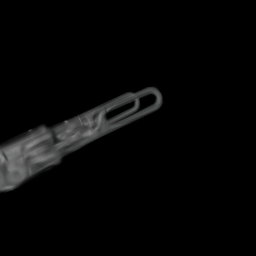

In [129]:
## ------ Save the video ------ ##
make_video(videos, "tracking_sequence", fps=25)
IPImage(filename="tracking_sequence.gif")


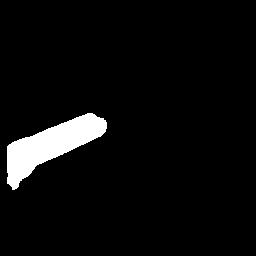

In [130]:
IPImage(filename="mask.gif")


In [131]:
trans_results

[tensor([-0.3448,  0.1836, -0.2531]),
 tensor([-0.3447,  0.1835, -0.2532]),
 tensor([-0.3445,  0.1834, -0.2537]),
 tensor([-0.3443,  0.1834, -0.2543]),
 tensor([-0.3441,  0.1834, -0.2549]),
 tensor([-0.3439,  0.1835, -0.2555]),
 tensor([-0.3436,  0.1837, -0.2560]),
 tensor([-0.3434,  0.1839, -0.2565]),
 tensor([-0.3432,  0.1841, -0.2570]),
 tensor([-0.3431,  0.1842, -0.2572]),
 tensor([-0.3431,  0.1839, -0.2574]),
 tensor([-0.3431,  0.1836, -0.2576]),
 tensor([-0.3430,  0.1834, -0.2578]),
 tensor([-0.3429,  0.1833, -0.2581]),
 tensor([-0.3427,  0.1831, -0.2584]),
 tensor([-0.3425,  0.1831, -0.2590]),
 tensor([-0.3424,  0.1831, -0.2592]),
 tensor([-0.3424,  0.1831, -0.2592]),
 tensor([-0.3424,  0.1831, -0.2590]),
 tensor([-0.3425,  0.1832, -0.2587]),
 tensor([-0.3425,  0.1837, -0.2584]),
 tensor([-0.3428,  0.1839, -0.2582]),
 tensor([-0.3430,  0.1838, -0.2574]),
 tensor([-0.3433,  0.1838, -0.2567]),
 tensor([-0.3435,  0.1838, -0.2561]),
 tensor([-0.3435,  0.1837, -0.2558]),
 tensor([-0.

In [132]:
## plot the translation results
## 3D plot




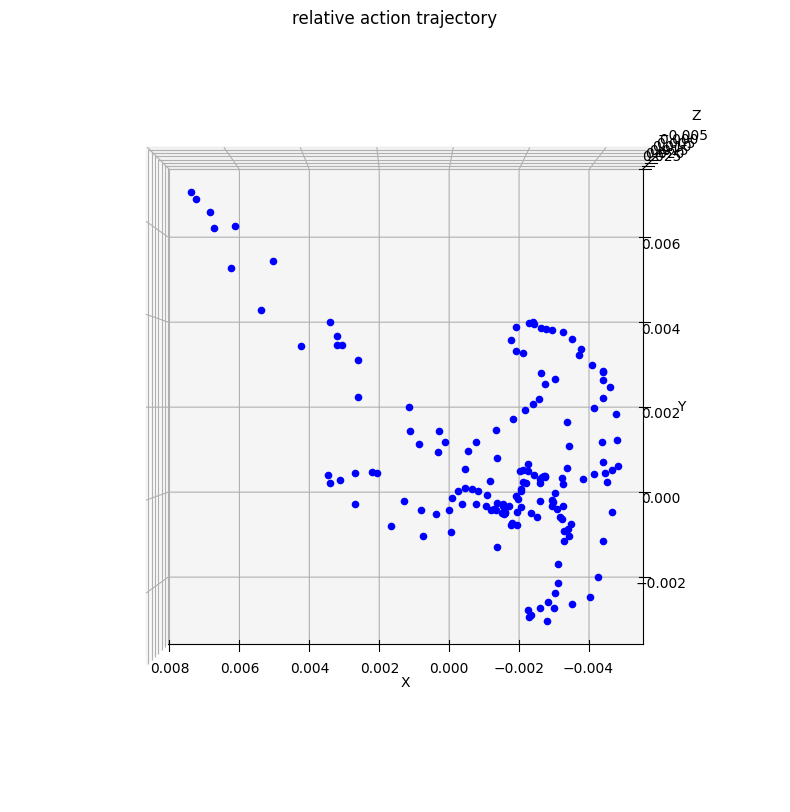

In [133]:
## read the csv file
import pandas as pd
ee_csv_path = "/home/iulian/chole_ws/src/sam2/data/tissue_80/grab/ee_csv.csv"
ee_csv = pd.read_csv(ee_csv_path)
header_name_qpos_psm1 = ["psm1_pose.position.x", "psm1_pose.position.y", "psm1_pose.position.z",
                        "psm1_pose.orientation.x", "psm1_pose.orientation.y", "psm1_pose.orientation.z", "psm1_pose.orientation.w",
                        "psm1_jaw"]

header_name_qpos_psm2 = ["psm2_pose.position.x", "psm2_pose.position.y", "psm2_pose.position.z",
                        "psm2_pose.orientation.x", "psm2_pose.orientation.y", "psm2_pose.orientation.z", "psm2_pose.orientation.w",
                        "psm2_jaw"]

ee_l_qpos = ee_csv[header_name_qpos_psm2].to_numpy()
ee_l_qpos_init = ee_l_qpos[0]
## normalize the data (substract with the initial pose)
ee_l_qpos = ee_l_qpos - ee_l_qpos_init
results = []
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
trans_init = trans_results[0].detach().cpu().numpy()
for r in trans_results:
    res = r.detach().cpu().numpy()
    res = res-trans_init
    ax.scatter(-res[0], -res[1], res[2], c="b")
# print(results[1])
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.view_init(-90, 90)

# # plt.show()
# ax = fig.add_subplot(121, projection='3d')
# ax.scatter(ee_l_qpos[:, 0], ee_l_qpos[:, 1], ee_l_qpos[:, 2], c="r")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
## look from the top
ax.view_init(-90, 90)
## set title
plt.title("relative action trajectory")
# ax.legend(["robot", "human"])
plt.show()